### Multi-armed bandit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### The BernoulliBandit

In [2]:
class BernoulliBandit:
    def __init__(self,  K):
        self.probs = np.random.uniform(size = K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K
    
    def step(self, k):
        ## player choose the k_idx banit
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

np.random.seed(1)
K = 10 # a ten-arms banit
bandit_10_arm = BernoulliBandit(K)
print("Random generation of a {}-arms-bandit".format(K))
print("The best idx of this banit is {}, the highest prob. is {:.4f}".
      format(bandit_10_arm.best_idx, bandit_10_arm.best_prob))

Random generation of a 10-arms-bandit
The best idx of this banit is 1, the highest prob. is 0.7203


In [3]:
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit # the bandit class object
        self.counts = np.zeros(self.bandit.K)
        self.total_regret = 0
        self.actions = []
        self.regrets = [] # the total_regret of every step
        
    def update_regret(self, k):
        # the real world is objective
        self.total_regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.total_regret)
    
    def run_one_step(self):
        raise NotImplementedError
    
    def run(self, times = 5000):
        for _ in range(times):
            k = self.run_one_step() # specific choose which arms
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

#### Epsilon-Greedy

In [4]:
class EpsilonGreedy(Solver): 
    # class child(father): child inherit the properties and methods from the father class
    def __init__(self, bandit, epsilon = 0.01, int_prob = 1.0):
        super(EpsilonGreedy, self).__init__(bandit) # why bandit? the initial of solver class need bandit
        self.epsilon = epsilon
        self.estimates = np.array([int_prob] * self.bandit.K)
    
    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, high = self.bandit.K) #Return random integers from [low, high)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)  #the reward for this action
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

EpsilonGreedy's cumulative regrets is 25.526631


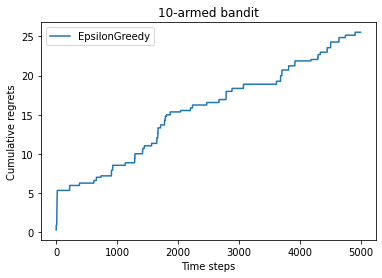

In [5]:
def plot_result(solvers, solver_names):
    ## solvers is a list, each element is a policy
    ## solver_names: list, the names of each policy
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label = solver_names[idx])
    plt.xlabel("Time steps")
    plt.ylabel("Cumulative regrets")
    plt.title("{}-armed bandit".format(solvers[0].bandit.K))
    plt.legend()
    plt.show()

np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon = 0.01)
epsilon_greedy_solver.run(times = 5000)
print("EpsilonGreedy's cumulative regrets is {:4f}".format(epsilon_greedy_solver.total_regret))
plot_result([epsilon_greedy_solver], ["EpsilonGreedy"])
    

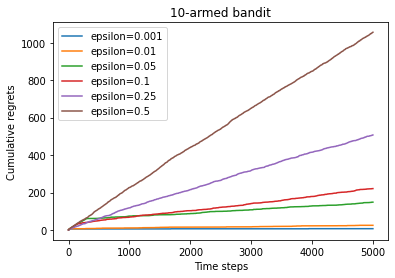

In [6]:
#### the choose of different epsilon
np.random.seed(1)
times = 5000
epsilons = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5]
epsilon_solver_list = [EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons]
epsilon_solver_name = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_solver_list:
    solver.run(times)
plot_result(epsilon_solver_list, epsilon_solver_name)

DecayingEpsilonGreedy's cumulative regrets is 10.114335


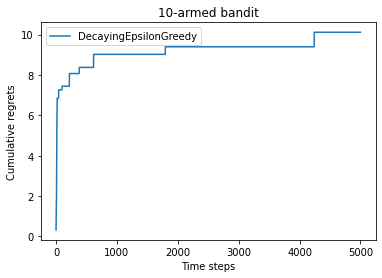

In [7]:
class DecayingEpsilonGreedy(Solver):
    ### epsilon is decaying with time
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0
    
    def run_one_step(self):
        self.total_count += 1
        # Return random floats in the half-open interval [0.0, 1.0)
        if np.random.random() < 1 / self.total_count:  # decay the epsilon with time
            k = np.random.randint(0, high = self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
        
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(times = 5000)
print("DecayingEpsilonGreedy's cumulative regrets is {:4f}".format(decaying_epsilon_greedy_solver.total_regret))
plot_result([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

#### Upper Confidence Bound Algorithm (UCB)

UCB_Solver's cumulative regrets is 89.408650


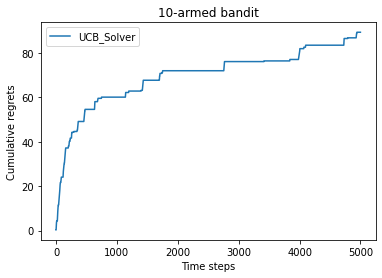

In [8]:
class UCB(Solver):
    def __init__(self, bandit, coef=1, init_prob=1.0, p=None):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef
        self.p = p
    
    def run_one_step(self):
        self.total_count += 1
        ## p = 1 / t, the choose of p
        if self.p == None:
            p = 1 / self.total_count
        else:
            p = self.p
        ucb =  self.estimates + self.coef * np.sqrt((-1) * np.log(p) / (2 * self.counts + 1))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

np.random.seed(1)
coef = 1
UCB_Solver = UCB(bandit_10_arm, coef=coef)
UCB_Solver.run(times = 5000)
print("UCB_Solver's cumulative regrets is {:4f}".format(UCB_Solver.total_regret))
plot_result([UCB_Solver], ["UCB_Solver"])

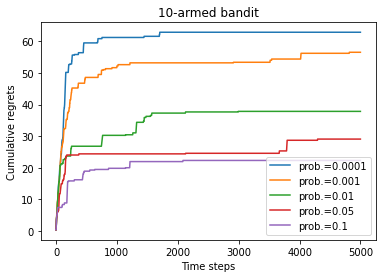

In [9]:
np.random.seed(1)
coef = 1
probs = [0.0001, 0.001, 0.01, 0.05, 0.1]
UCB_Solver_list = [UCB(bandit_10_arm, coef=coef, p=p) for p in probs]
UCB_Solver_name = ["prob.={}".format(p) for p in probs]
for solver in UCB_Solver_list:
    solver.run(times = 5000)
plot_result(UCB_Solver_list, UCB_Solver_name)

#### Thompson sampling

ThompsonSampling's cumulative regrets is 57.191620


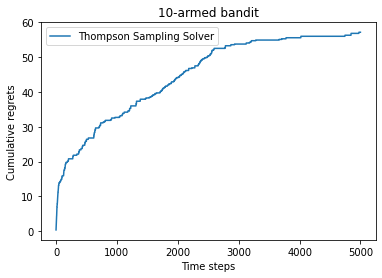

In [10]:
class ThompsonSampling(Solver):
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)
        self._b = np.ones(self.bandit.K)
    
    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)
        self._a[k] += r
        self._b[k] += (1 - r)
        return k
    
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print("ThompsonSampling's cumulative regrets is {:4f}".format(thompson_sampling_solver.total_regret))
plot_result([thompson_sampling_solver], ["Thompson Sampling Solver"])
    